In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
import datetime as dt
from datetime import timedelta
import os
import matplotlib as mpl

#silence setting with copy warning
pd.set_option('mode.chained_assignment', None)

Define feet to meters conversion:

In [2]:
fttom = 0.3048

Define gagename and gagenumber

In [18]:
gagename = 'Skagit Near Mt. Vernon'
gageno = '12200500'

Import data

In [59]:
measurement_data = pd.read_csv(r'example_data_Skagit Near Mt. Vernon_12200500_measurement_data.csv')
measurement_data['measurement_dt'] = pd.to_datetime(measurement_data.measurement_dt)
mean_daily_data = pd.read_csv(r'example_data_Skagit Near Mt. Vernon_12200500_mean_daily_data.csv')
mean_daily_data['datetime'] = pd.to_datetime(mean_daily_data['datetime'])
rating_curve = pd.read_csv(r'example_rating_curve_Skagit Near Mt. Vernon_12200500_posterior_rating.csv', sep=';')

Define flood stage for site:

In [5]:
flood_stage = 8.5 #m for Skagit Nr Mt Vernon
flood_flow = np.interp(flood_stage, rating_curve['H[m]'] , rating_curve['Qmaxpost[m3/s]'])

Define trimming range

In [9]:
flood_depth = flood_stage - min(measurement_data.gage_height_m)
FD_filter_frac = 0.5 #filter to half flood depth
low_bound = flood_stage - FD_filter_frac*flood_depth
high_bound = flood_stage + FD_filter_frac*flood_depth
high_bound = max(measurement_data.gage_height_m)
FD_filter = (measurement_data.gage_height_m > low_bound) & (measurement_data.gage_height_m < high_bound)
trimmed_measurement_data = measurement_data[FD_filter]

Compute flow residuals:

In [12]:
#CALCULATE FLOW RESIDUALS 
trimmed_measurement_data['q_pred_cms'] = np.interp(
    trimmed_measurement_data.gage_height_m,
    rating_curve['H[m]'],
    rating_curve['Qmaxpost[m3/s]']
)
trimmed_measurement_data['q_resid_cms'] = trimmed_measurement_data['discharge_cms'] - trimmed_measurement_data['q_pred_cms']

Filter flow residuals to within 3 std of moving 10 pt median

In [54]:
trimmed_measurement_data['median']= trimmed_measurement_data['q_resid_cms'].rolling(10).median()
trimmed_measurement_data['median'] = trimmed_measurement_data['median'].fillna(method='bfill')
trimmed_measurement_data['std'] = trimmed_measurement_data['q_resid_cms'].rolling(10).std()
trimmed_measurement_data['std'] = trimmed_measurement_data['std'].fillna(method='bfill')
n_std = 3 #define the number of standard deviations
std_filter = (trimmed_measurement_data.q_resid_cms <= trimmed_measurement_data['median']+n_std*trimmed_measurement_data['std']) & (trimmed_measurement_data.q_resid_cms >= trimmed_measurement_data['median']-n_std*trimmed_measurement_data['std'])
filtered_measurement_data = trimmed_measurement_data[std_filter]

Create new moving 5-pt median of this filtered data

In [55]:
filtered_measurement_data['q_resid_cms_med'] = filtered_measurement_data['q_resid_cms'].rolling(5).median(centered=True)

Plots of measurement data

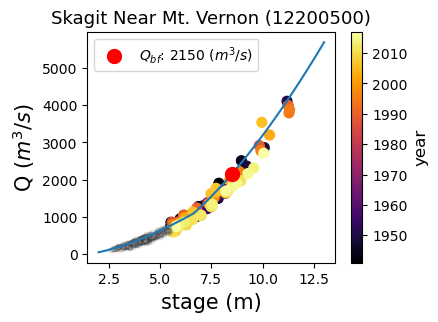

In [115]:
fig, ax = mp.subplots(figsize=(4,3))

#plot rating curve
ax.plot(
    rating_curve['H[m]'][rating_curve['Qmaxpost[m3/s]']>0],
    rating_curve['Qmaxpost[m3/s]'][rating_curve['Qmaxpost[m3/s]']>0]
)
#plot data being analyzed
im = ax.scatter(
    measurement_data[FD_filter].gage_height_m,
    measurement_data[FD_filter].discharge_cms,
    c=measurement_data[FD_filter].measurement_dt.dt.year,
    s=50,
    cmap='inferno'
)
#plot data outside trimming bounds
measurement_data[measurement_data.gage_height_m < low_bound].plot.scatter(
    x='gage_height_m',
    y='discharge_cms',
    c='gainsboro',
    ax=ax,
    s=10,
    edgecolor='k',
    alpha=0.1,
    style='o')
measurement_data[measurement_data.gage_height_m > high_bound].plot.scatter(
    x='gage_height_m',
    y='discharge_cms',
    c='gainsboro',
    ax=ax,
    s=10,
    edgecolor='k',
    alpha=0.1,
    style='o')
#plot point of flood stage
ax.scatter(
    flood_stage,
    flood_flow,
    color='red',
    s=100,
    zorder=3,
    label='$Q_{bf}$: %.0f ($m^3/s$)'%(round(flood_flow, -1))
)

ax.set_xlabel('stage (m)', fontsize=15)
ax.set_ylabel('Q ($m^3/s$)', fontsize=15)
ax.set_title('%s (%s)'%(gagename, gageno), fontsize=13)
ax.legend()
mp.colorbar(im).set_label('year', fontsize=12)
mp.show(fig)

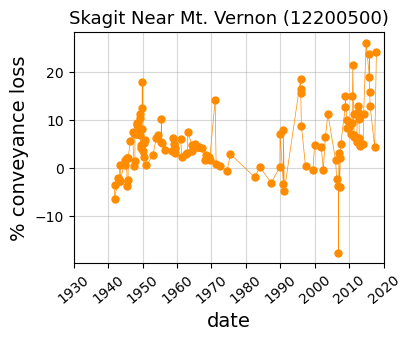

In [57]:
fig, ax = mp.subplots(figsize=(4,3))
p1=ax.plot(
    filtered_measurement_data['measurement_dt'],
    filtered_measurement_data['q_resid_cms']/flood_flow*100*(-1),
    c='darkorange',
    marker='o',
    markersize=5,
    linewidth=0.5
)
ax.set_xlabel('date', fontsize=14)
ax.set_ylabel('% conveyance loss', fontsize=14)
ax.set_title('%s (%s)'%(gagename, gageno), fontsize=13)
ax.set_xlim(pd.to_datetime('01-01-1930'), pd.to_datetime('01-01-2020'))
mp.xticks(rotation=40)
ax.grid(alpha=0.5)

mp.show(fig)

## Compute change in flow at constant return period

In [77]:
mean_daily_data = mean_daily_data.dropna(subset=['discharge_cms']).reset_index(drop=True) #drop nans (screw up FDC ranking)

no_yrs_per_window=10 #number of years to include in each dataspan for creating flow-duration curves
days_per_window = 365*no_yrs_per_window
window_size = dt.timedelta(days=days_per_window) #datetime object for shifting data
d_window_shift = 365 #days to shift window over by before creating next FDC and interpolating Q(RP)

Determine return period of flood flow predicted by rating curve for same time period:

In [78]:
rating_curve_mid_date = pd.to_datetime('1946-10-10')

In [79]:
#create filter to observe data spanning 1/2 either side of max capacity data
date_filter = [rating_curve_mid_date - dt.timedelta(days=no_yrs_per_window/2*365),
               rating_curve_mid_date + dt.timedelta(days=no_yrs_per_window/2*365)]

In [80]:
mean_daily_subset = mean_daily_data[(mean_daily_data['datetime'] >= date_filter[0]) & 
                            (mean_daily_data['datetime'] <= date_filter[1])]
mean_daily_subset = mean_daily_subset.dropna(subset=['discharge_cms']).reset_index(drop=True) #drop nans (screws up FDC ranking)

Define function to compute return period of mean daily subset

In [81]:
def find_RP(x, flood_flow):
    P = 1 - np.arange(1, len(x)+1)/(1 + len(x))
    RP = 1/(P)
    RP_days = np.interp(flood_flow,
                        np.sort(x),
                        np.sort(RP))
    return(RP, RP_days)

In [82]:
RPs, rp_rating_flood_flow_days = find_RP(mean_daily_subset.discharge_cms, flood_flow)
rp_rating_flood_flow_years = rp_rating_flood_flow_days/365
rp_rating_flood_flow_years

1.7309665651278445

In [83]:
start = min(mean_daily_data['datetime'])
end = max(mean_daily_data['datetime'])
t = pd.to_datetime(
    np.arange(start, end-window_size, dt.timedelta(days=d_window_shift), dtype=np.datetime64)
) #uses test truncate to test on smaller dataset
rp_flows = np.zeros(len(t)) #create vector to hold rp flows
rps = pd.DataFrame() #rows hold time, colums hold RPs for each subset_window
qs = pd.DataFrame() #rows hold time, columns hold flows for each subset_window


Define function to find the flow through moving window of time

In [84]:
def find_RP_flow(x, RP): #RP in days
    P = 1 - np.arange(1, len(x)+1)/(1 + len(x))
    RP = 1/(P)
    q_RP = np.interp(rp_days,
                     np.sort(RP),
                     np.sort(x))
    RP = pd.Series(RP) #if rp is dataframe
    return(q_RP, RP)

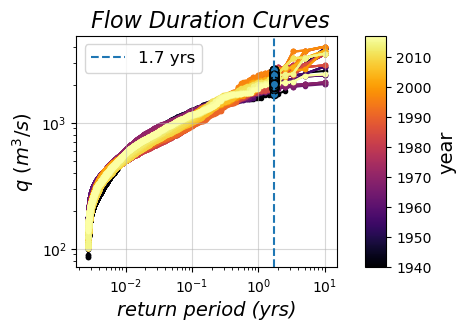

In [109]:
color_i = np.linspace(0, 1, int(len(t)))
# f, ax = mp.subplots(figsize=(3.5,3))
f, (ax0, ax1) = mp.subplots(1, 2, figsize=(4,3), gridspec_kw={'width_ratios': [3, 0.25]})

for i, window_start in enumerate(t):
    
    window_end = window_start + window_size
    
    subset = mean_daily_data[
        (mean_daily_data['datetime']  >= window_start) &
        (mean_daily_data['datetime'] < window_end)
    ].reset_index(drop=True)
    
    #only compute a flow if subset of data is sufficiently complete (has at least 8 years of data)
    if len(subset) > 8*365:
        rp_flows[i], rps = find_RP_flow(subset.discharge_cms, rp_days) 
        ax0.loglog(
            rps/365, np.sort(subset.discharge_cms),
            color=mp.cm.inferno(color_i[i]),
            marker='o',
            markersize=3,
            zorder=1
        )
        ax0.scatter(
            rp_days/365,
            find_RP_flow(subset.discharge_cms, rp_days)[0],
            color='C0',
            edgecolor='k',
            zorder=2
        )
    else:
        rp_flows[i] = np.nan
        
ax0.set_xlabel('return period (yrs)', fontsize=14, fontstyle='italic')
ax0.set_ylabel('q $(m^3/s)$', fontsize=14, fontstyle='italic')
ax0.set_title(' Flow Duration Curves',
             fontsize=16, fontstyle='italic')
ax0.axvline(rp_days/365,
           color='C0',
           linestyle='--',
           label='%.1f yrs'%rp_years)
ax0.legend(fontsize=12)
ax0.grid(True,
        alpha=0.5,
        zorder=0)

#create colorbar
cmap = mpl.cm.inferno
norm = mpl.colors.Normalize(
    vmin=min(mean_daily_data['datetime'].dt.year),
    vmax=max(mean_daily_data['datetime'].dt.year)
)
cb1 = mpl.colorbar.ColorbarBase(
    ax1,
    cmap=cmap,
    norm=norm,
    orientation='vertical'
)
cb1.set_label('year', fontsize=14)

mp.show(f)

Plot hydrologic changes over time

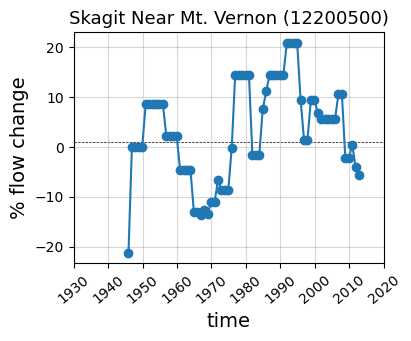

In [113]:
f, ax = mp.subplots(figsize=(4,3))
ax.plot(t+pd.Timedelta(365*(no_yrs_per_window/2), unit='days'), (rp_flows/flood_flow-1)*100,
        marker='o', zorder=2)
ax.set_xlabel('time', fontsize=14)
ax.axhline(1, linewidth=0.5, color='k', linestyle='--', zorder=1)
ax.set_ylabel('% flow change', fontsize=14)
ax.set_xlim(pd.to_datetime('01-01-1930'), pd.to_datetime('01-01-2020'))
ax.set_title('%s (%s)'%(gagename, gageno), fontsize=13)
mp.xticks(rotation=40)
ax.grid(True,
        alpha=0.5)
mp.show(f)